# Motivating Example: Testing Exchangeability

Testing whether a data sample is exchangeable (e.g., IID) is a nontrivial problem for which different e-processes are constructed using different filtrations.

We show empirically that e-processes constructed w.r.t. a coarser filtration (namely, conformal test martingales) are not valid at stopping times w.r.t. the data filtration.

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import seaborn as sns
import os

import ecombine as ec

In [2]:
# basic figure styles
ec.set_theme()

# rng for data generation and inference methods, separately
rng_data = np.random.default_rng(20231121)
rng = np.random.default_rng(12113202)

# plots saved here
plots_dir = "./plots/exch"
os.makedirs(plots_dir, exist_ok=True)
mpl.rc("savefig", format="pdf", dpi=300)

colors = sns.color_palette("colorblind")

## False positives at F-stopping times for the conformal test martingale

Let $\mathbb{F} = (\mathcal{F}_t)_{t\geq0}$ be the data filtration, that is,
$$
\mathcal{F}_t = \sigma(X_1, \dotsc, X_t).
$$

Unlike the UI e-process, the conformal e-process is NOT valid w.r.t. $\mathbb{F}$; it is only valid w.r.t. $\mathbb{G} = (\mathcal{G}_t)_{t\geq0}$, where
$$
\mathcal{G}_t = \sigma(p_1, \dotsc, p_t)
$$
is the filtration according to the conformal p-values.
In our case, the conformal p-value implicitly measures how much bias there is towards either outcome.

We consider the following $\mathbb{F}$-stopping time, which is NOT $\mathbb{G}$-adapted:
$$
\tau(k) = \inf \{t \geq k: (X_{t-k+1}, \dotsc, X_{t}) = (0, \dotsc, 0)\} \wedge T, 
$$
that is, the first time that $k$ consecutive zeros occur in the sequence. This is clearly adapted to the data sequence, but it cannot be deduced directly from $\mathbb{G}$.
$T$ denotes the maximum length of the sequence.


In [3]:
def stopping_match(x, string):
    """Return the (0-indexed) stopping time for
    whether k consecutive strings match a specific string."""
    x = np.array(x)
    T = len(x)
    tau = T
    k = len(string)
    if T < k:
        return tau
    
    for t in range(k, T + 1):
        if (x[t-k:t] == string).all():
            tau = t - 1
            break
    return tau

Having defined a stopping time, we can compute the e-process on repeatedly sampled data to compute the empirical mean of the stopped e-values
$$
\hat{\mathbb{E}}[\mathfrak{e}_\tau].
$$

Given that the data is generated from a null distribution (IID), this expectation must be $\leq 1$ for any $\mathbb{G}$-stopping times $\tau$, although not necessarily for $\mathbb{F}$-stopping times.
We now simulate and compute both the UI and conformal e-processes to obtain their stopped e-values.

In [4]:
p = 0.3                  # null distribution probability
T = 100                  # max sequence length
n_repeats = 10000        # number of repeated experiments
match_string = np.array([0, 0, 0, 0, 0])  # string to match

# conformal
jump = 0.01
jumper_weights = (0, 0, 1)  # only bet on (p - 1/2)

Alternative config (higher variance):

In [5]:
# p = 0.5                  # null distribution probability
# T = 200                  # max sequence length
# n_repeats = 10000        # number of repeated experiments
# match_string = np.array([[0, 0, 0, 0, 0],
#                          [1, 1, 1, 1, 1]]) # strings to match

# # conformal
# jump = 0.01
# jumper_weights = (0.5, 0, 0.5)

In [6]:
data_generator = lambda n: ec.data.exch.generate_binary_iid(
    p=p, 
    size=n, 
    rng=rng_data,
)
eprocess_fns = {
    "UI": ec.eprocess_exch_universal,
    "Conformal": lambda x: ec.eprocess_exch_conformal(
        x, jump=jump, jumper_weights=jumper_weights, rng=rng
    ),
    "E-lifted": lambda x: ec.adjuster(
        ec.eprocess_exch_conformal(
            x, jump=jump, jumper_weights=jumper_weights, rng=rng
        ),
        use_maximum=True,
    ),
}

dfs, estop_dfs = {}, {}
for method, eprocess_fn in eprocess_fns.items():
    df, estop_df = ec.compute_e_and_stopping(
        data_generator,
        eprocess_fn,
        lambda x: stopping_match(x, string=match_string),
        n_repeats=n_repeats,
        T=T,
    )
    dfs[method] = df
    estop_dfs[method] = estop_df
    # for labeling plots
    dfs[method]["E-process"] = method
    estop_dfs[method]["E-process"] = method

compute_e_and_stopping repeated trials: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:04<00:00, 2071.75it/s]


We can print some summary statistics of the stopped e-values:

In [7]:
def print_summary(estop_df, file=None):
    """Print a quick summary of stopped e-values."""
    n = len(estop_df)  # number of simulations
    m_tau = estop_df.tau.mean()
    frac_unstopped = (estop_df.tau == T).mean()
    m_e_stopped = estop_df.e_stopped.mean()
    se_e_stopped = estop_df.e_stopped.std() / np.sqrt(n)
    print(f"empirical mean of F-stopped e-values (N={n}, T={T}): "
          f"{m_e_stopped:.5f} +/- {se_e_stopped:.5f}", file=file)
    print(f"mean stopping time: {m_tau.mean():.5f}", file=file)
    print(f"fraction of unstopped e-values up to {T} steps: "
          f"{frac_unstopped:.5f}", file=file)

In [8]:
for method, estop_df in estop_dfs.items():
    print(f"[{method} e-process]")
    print_summary(estop_df)
    with open(os.path.join(plots_dir, f"stopped_e_{method.lower()}.txt"), "w") as f:
        print_summary(estop_df, file=f)

[UI e-process]
empirical mean of F-stopped e-values (N=10000, T=100): 0.24960 +/- 0.00756
mean stopping time: 15.29970
fraction of unstopped e-values up to 100 steps: 0.00040
[Conformal e-process]
empirical mean of F-stopped e-values (N=10000, T=100): 1.31154 +/- 0.01461
mean stopping time: 15.46640
fraction of unstopped e-values up to 100 steps: 0.00050
[E-lifted e-process]
empirical mean of F-stopped e-values (N=10000, T=100): 0.47484 +/- 0.00300
mean stopping time: 15.49660
fraction of unstopped e-values up to 100 steps: 0.00060


The conformal stopped e-values exceeds 1 in expectation!

## Figure 1: comparing UI and conformal

We now look at the histogram of stopped e-values for the UI and conformal e-processes.

In [9]:
# fix unique colors
hue_order = [m for m in dfs]

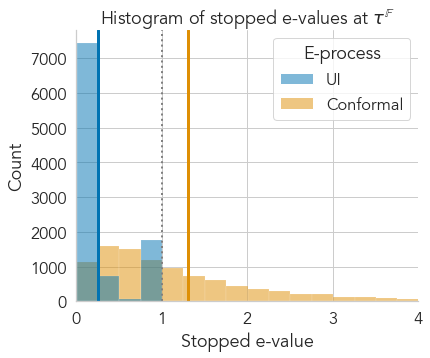

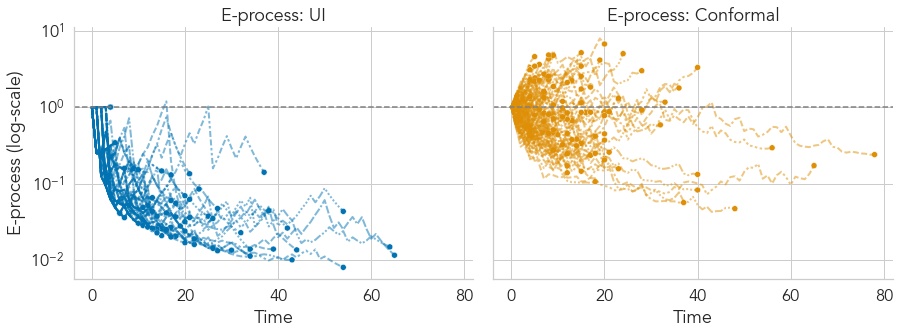

In [10]:
methods = ["UI", "Conformal"]

fg_hist, fg_e = ec.plot_stopped_e_values(
    {m: df for m, df in dfs.items() if m in methods},
    {m: edf for m, edf in estop_dfs.items() if m in methods},
    hue_order=hue_order,
    plots_dir=os.path.join(plots_dir, "figure1"),
)

## Figure 2: comparing conformal and its e-lifted (adjusted) version

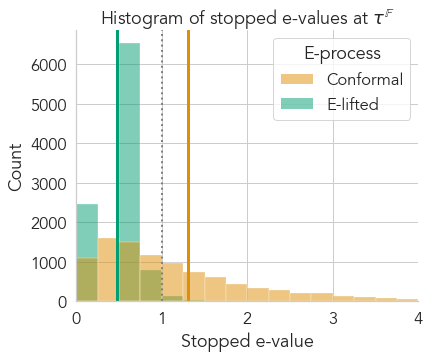

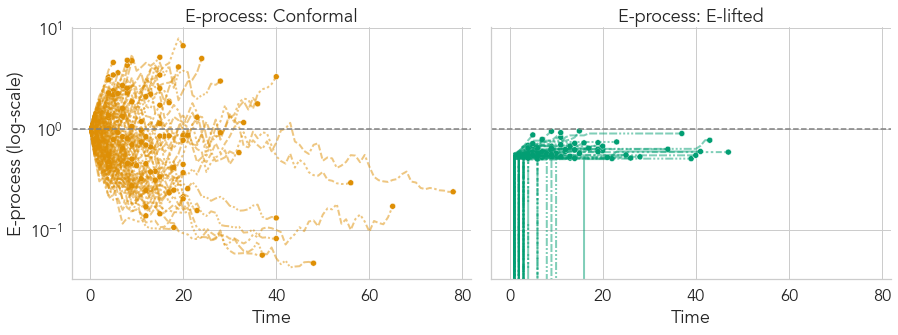

In [11]:
methods = ["Conformal", "E-lifted"]

fg_hist, fg_e = ec.plot_stopped_e_values(
    {m: df for m, df in dfs.items() if m in methods},
    {m: edf for m, edf in estop_dfs.items() if m in methods},
    hue_order=hue_order,
    plots_dir=os.path.join(plots_dir, "figure2"),
)